
Finding Price of Zero-Coupon Bonds using Black-Scholes-esque argument of dynamic hedging. Short rate, $y_t$ given using Ornstein-Uhlenbeck process <br>
 $ dy_t = \alpha (\bar y - y_t)dt + \sigma dB $ <br>


Let $ V = V(t, T, y_t) $ (Shortened Derivation) <br>
Setting up following portfolio of two bonds eliminating all risk allowing us to use $r_f$ <br>
$ \pi = q_1 V_1 + q_2 V_2, \frac{q_1}{q_2} = -\frac{\partial V_2/\partial y}{\partial V_1/\partial y}$

Then just using Ito's lemma, reordering a few terms, <br>
$ \frac{\partial V}{\partial t} + \frac{\sigma ^ 2}{2}\frac{\partial^2V}{\partial y^2} - yV + \alpha(\bar y - y)\frac{\partial V}{\partial y} = 0$

Guess for solving it using following Ansatz. Boundary condition of $ V = 1, t = T $ <br>
Ansatz: $ V(t, y) = e^{(f(t)-yg(t))} $
Substitutiting into PDE and rearranging s.t. it reduces to system of two ODEs <br>
$ \frac{df}{dt} = g \alpha  \bar y - \frac{\sigma^2g^2}{2} $ <br>
$ \frac{dg}{dt} = -1 + g\alpha $ <br>

Solving to, also imposing boundary conditions to calculate integration constants,<br>
$ g(t) =  \frac{1}{\alpha}(1-e^{-\alpha(T-t)})  $ <br>
$ f(t) = \bar y [-(T-t) + \frac{1}{\alpha} (1-e^{(-\alpha(T-t))}] + \frac{\sigma ^2}{4 \alpha ^ 3}[2 \alpha (T-t) - 4(1 - e^{(-\alpha(T-t))} + (1-e^{(-2 \alpha(T-t))}))]$ 


Just using some back-of-the-head parameter estimates for Ornstein-Uhlenbeck that seem fair to EU/US monetary environment, (A lot of room for improvement, parameter estimation seems like an interesting project)
* $ \bar y $ = 3% $
* $ \alpha = 0.2 $
* $ \sigma = 0.05 $ 

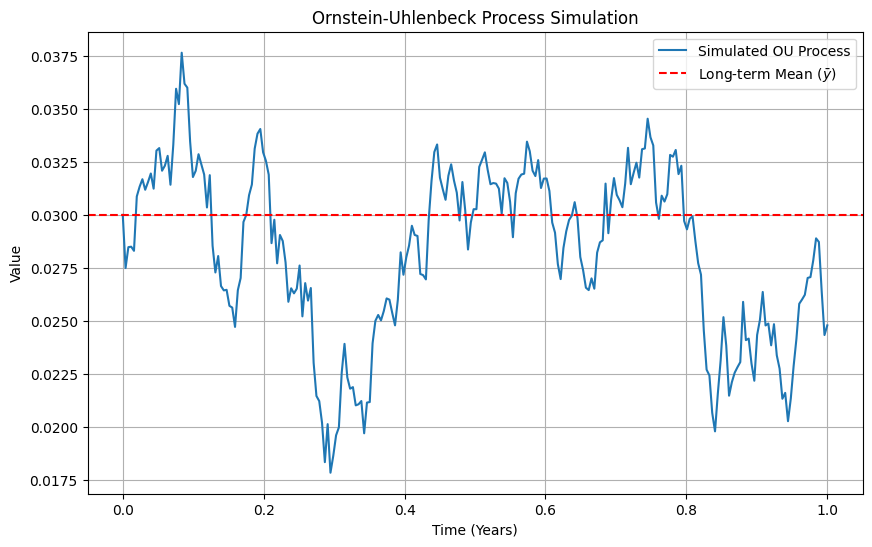

In [10]:
import numpy as np
import matplotlib.pyplot as plt

y_bar = 0.03  
alpha = 0.1 
sigma = 0.02
dt = 1 / 252 
T = 1 
y0 = 0.03  
n_steps = int(T / dt) 

y = np.zeros(n_steps)
y[0] = y0


for t in range(1, n_steps):
    Z = np.random.normal(0, 1)
    y[t] = y[t - 1] + alpha * (y_bar - y[t - 1]) * dt + sigma * np.sqrt(dt) * Z

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, n_steps), y, label='Simulated OU Process')
plt.axhline(y_bar, color='r', linestyle='--', label='Long-term Mean ($\\bar{y}$)')
plt.xlabel('Time (Years)')
plt.ylabel('Value')
plt.title('Ornstein-Uhlenbeck Process Simulation')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
#loading the data, just using data for 10-year American zero-coupon bonds
import pandas as pd

file_path = 'us10yrZero.csv'
market_data = pd.read_csv(file_path)

market_data.head()

,date,conf,status1,s1
0,2013-03-31,NaN,Normal value,2.0874
1,2013-06-30,NaN,Normal value,2.8241
2,2013-09-30,NaN,Normal value,2.9054
3,2013-12-31,NaN,Normal value,3.2659
4,2014-03-31,NaN,Normal value,2.9713


In [46]:
def g_t(t, alpha, T):
    return (1/alpha) * (1 - np.exp(-alpha * (T - t)))

def f_t(t, alpha, y_bar, sigma, T):
    term1 = 1 / (4 * alpha ** 3)
    term2 = 2 * alpha * (T - t) * (2 * alpha ** 2 * y_bar - sigma ** 2) * np.exp(2 * alpha * (T - t))
    term3 = sigma ** 2
    term4 = (-4 * alpha ** 2 * y_bar + 3 * sigma ** 2) * np.exp(2 * alpha * (T - t))
    term5 = 4 * (alpha ** 2 * y_bar - sigma ** 2) * np.exp(alpha * (T - t))
    return term1 * (term2 + term3 + term4 + term5) * np.exp(-2 * alpha * (T - t))

def V_t_y(t, y, alpha, y_bar, sigma, T):
    f = f_t(t, alpha, y_bar, sigma, T)
    g = g_t(t, alpha, T)
    return np.exp(f - y * g)

#computing the time in years to maturity for each data point
market_data['date'] = pd.to_datetime(market_data['date'])
market_data['time_to_maturity'] = T - (market_data['date'].dt.year + market_data['date'].dt.dayofyear / 365 - 2013)

# Compute V(t, y) for each data point
market_data['V_t_y'] = V_t_y(market_data['time_to_maturity'], market_data['s1'], alpha, y_bar, sigma, T)

market_data.head()

,date,conf,status1,s1,time_to_maturity,V_t_y
0,2013-03-31,NaN,Normal value,2.0874,9.753425,0.601506
1,2013-06-30,NaN,Normal value,2.8241,9.504110,0.255143
2,2013-09-30,NaN,Normal value,2.9054,9.252055,0.123315
3,2013-12-31,NaN,Normal value,3.2659,9.000000,0.044756
4,2014-03-31,NaN,Normal value,2.9713,8.753425,0.030799


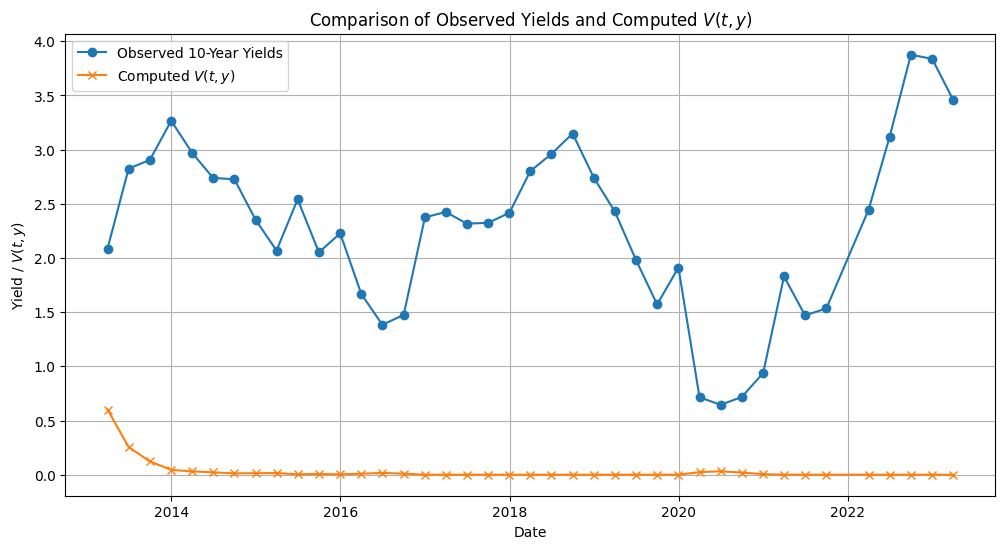

In [37]:
# Plot the computed V(t, y) against the observed 10-year yields
plt.figure(figsize=(12, 6))

# Plot observed yields
plt.plot(market_data['date'], market_data['s1'], label='Observed 10-Year Yields', marker='o')

# Plot computed V(t, y)
plt.plot(market_data['date'], market_data['V_t_y'], label='Computed $V(t, y)$', marker='x')

plt.xlabel('Date')
plt.ylabel('Yield / $V(t, y)$')
plt.title('Comparison of Observed Yields and Computed $V(t, y)$')
plt.legend()
plt.grid(True)
plt.show()

Woops, completely wrong market data given here, not supposed to track the yield, but function of V
Difficult to find this data w/o better access to e.g. Bloomberg Terminal, but we'll just infer it from yield curve data instead
<br>
$ P = \frac{F}{(1+y)^T} $

In [43]:
#from https://data.ecb.europa.eu/data/datasets/YC/YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_10Y
yield_data = pd.read_csv("yield_10yr.csv")
yield_data = yield_data.rename(columns={yield_data.columns[-1]: 'Yield'})
yield_data['Yield'] = yield_data['Yield'] / 100 

# Convert the DATE column to datetime format
yield_data['DATE'] = pd.to_datetime(yield_data['DATE'])

# Constants for bond price calculation
F = 1  # Face value of the bond s.t. it works with boundary condition standardization for solution
T = 10  # Time to maturity in years

# Calculate bond prices based on yields
yield_data['Bond_Price'] = F / (1 + yield_data['Yield']) ** T

yield_data.head()

,DATE,TIME PERIOD,Yield,Bond_Price
0,2004-09-06,06 Sep 2004,0.042092,0.662123
1,2004-09-07,07 Sep 2004,0.042096,0.662097
2,2004-09-08,08 Sep 2004,0.042284,0.660904
3,2004-09-09,09 Sep 2004,0.041619,0.665139
4,2004-09-10,10 Sep 2004,0.041210,0.667756


In [48]:
yield_data['time_to_maturity'] = T - (yield_data['DATE'].dt.year + yield_data['DATE'].dt.dayofyear / 365 - 2004)

# Compute V(t, y) for each data point using the closed-form solution
yield_data['V_t_y'] = V_t_y(yield_data['time_to_maturity'], yield_data['Yield'], alpha, y_bar, sigma, T)


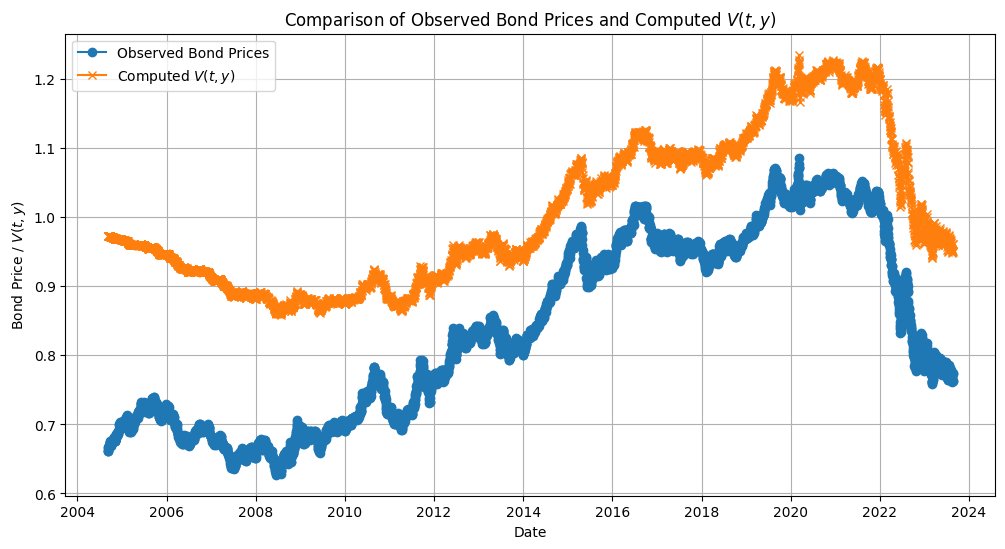

In [49]:
# Plot the computed V(t, y) against the observed bond prices
plt.figure(figsize=(12, 6))

# Plot observed bond prices
plt.plot(yield_data['DATE'], yield_data['Bond_Price'], label='Observed Bond Prices', marker='o')

# Plot computed V(t, y)
plt.plot(yield_data['DATE'], yield_data['V_t_y'], label='Computed $V(t, y)$', marker='x')

plt.xlabel('Date')
plt.ylabel('Bond Price / $V(t, y)$')
plt.title('Comparison of Observed Bond Prices and Computed $V(t, y)$')
plt.legend()
plt.grid(True)
plt.show()

Hmm, seems like it's just a scaling factor away. Trying to scale it to fit better, and then test on new data

In [52]:
from scipy.optimize import minimize

#Just a least squares minimisation.
def objective_function(lambda_value, observed_prices, modeled_prices):
    adjusted_modeled_prices = lambda_value * modeled_prices
    return np.sum((observed_prices - adjusted_modeled_prices) ** 2)

initial_lambda = 1.0

# Use scipy's minimize function to find the optimal lambda value
result = minimize(objective_function, initial_lambda, args=(yield_data['Bond_Price'], yield_data['V_t_y']))

optimal_lambda = result.x[0]
optimal_lambda

0.8366300616791091

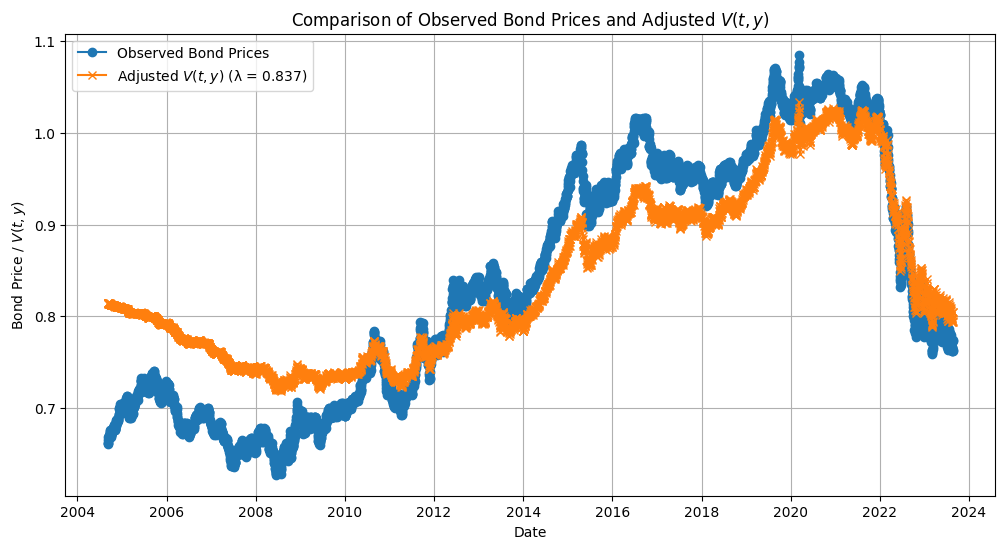

In [53]:
yield_data['V_t_y_adjusted'] = optimal_lambda * yield_data['V_t_y']

# Plot the updated V(t, y) against the observed bond prices
plt.figure(figsize=(12, 6))

# Plot observed bond prices
plt.plot(yield_data['DATE'], yield_data['Bond_Price'], label='Observed Bond Prices', marker='o')

# Plot computed V(t, y) with scaling factor
plt.plot(yield_data['DATE'], yield_data['V_t_y_adjusted'], label=f'Adjusted $V(t, y)$ (λ = {optimal_lambda:.3f})', marker='x')

plt.xlabel('Date')
plt.ylabel('Bond Price / $V(t, y)$')
plt.title('Comparison of Observed Bond Prices and Adjusted $V(t, y)$')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
new_yield_data = pd.read_csv('yield_5yr.csv')